In [14]:
import numpy as np
import torch

import nflows
import matplotlib.pyplot as plt

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
L = 8
lattice_shape = (L,L)
phi_ex1 = np.random.normal(size=lattice_shape).astype(np.float32)
phi_ex2 = np.random.normal(size=lattice_shape).astype(np.float32)
cfgs = torch.from_numpy(np.stack((phi_ex1, phi_ex2), axis=0)).to(device)

In [12]:
def grab(var):
    return var.detach().cpu().numpy()

In [10]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape

    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)

    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

In [7]:
class ScalarPhi4Action:
    def __init__(self, M2, lam):
        self.M2 = M2
        self.lam = lam

    def __call__(self, cfgs):
        # potential term
        action_density = self.M2*cfgs**2 + self.lam*cfgs**4
        
        # kinetic term (discrete Laplacian)
        Nd = len(cfgs.shape)-1
        dims = range(1,Nd+1)
        for mu in dims:
            action_density += 2*cfgs**2
            action_density -= cfgs*torch.roll(cfgs, -1, mu)
            action_density -= cfgs*torch.roll(cfgs, 1, mu)

        return torch.sum(action_density, dim=tuple(dims))

In [8]:
ScalarPhi4Action(M2=1.0, lam=1.0)(cfgs)

tensor([410.5288, 484.2784])

In [9]:
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

In [11]:
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

In [13]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')

z.shape = (1024, 8, 8)


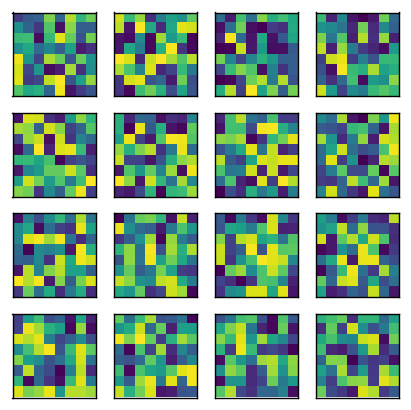

In [16]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

### Define flow in nflows

In [17]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(device)

In [18]:
make_checker_mask(lattice_shape, 0)

tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)

In [19]:
make_checker_mask(lattice_shape, 1)

tensor([[1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1]], dtype=torch.uint8)